# Entities

In [34]:
%matplotlib inline

import spacy
import random
import seaborn as sns

from spacy import displacy
from utils import hyperdash
from itertools import chain
from tqdm import tqdm_notebook
from collections import Counter

## Spacy 101

In [2]:
SAMPLE_TEXT = '''But Google is starting from behind. The company made a late push \
into hardware, and Apple’s Siri, available on iPhones, and Amazon’s Alexa \
software, which runs on its Echo and Dot devices, have clear leads in \
consumer adoption.'''

In [3]:
nlp = spacy.load('en')
doc = nlp(SAMPLE_TEXT)

In [4]:
print([(token.text, token.lemma_, token.norm_, token.pos_, token.sentiment) for token in doc])

[('But', 'but', 'but', 'CCONJ', 0.0), ('Google', 'google', 'google', 'PROPN', 0.0), ('is', 'be', 'is', 'VERB', 0.0), ('starting', 'start', 'starting', 'VERB', 0.0), ('from', 'from', 'from', 'ADP', 0.0), ('behind', 'behind', 'behind', 'ADV', 0.0), ('.', '.', '.', 'PUNCT', 0.0), ('The', 'the', 'the', 'DET', 0.0), ('company', 'company', 'company', 'NOUN', 0.0), ('made', 'make', 'made', 'VERB', 0.0), ('a', 'a', 'gonna', 'DET', 0.0), ('late', 'late', 'late', 'ADJ', 0.0), ('push', 'push', 'push', 'NOUN', 0.0), ('into', 'into', 'into', 'ADP', 0.0), ('hardware', 'hardware', 'hardware', 'NOUN', 0.0), (',', ',', ',', 'PUNCT', 0.0), ('and', 'and', 'and', 'CCONJ', 0.0), ('Apple', 'apple', 'apple', 'PROPN', 0.0), ('’s', '’s', "'s", 'PART', 0.0), ('Siri', 'siri', 'siri', 'PROPN', 0.0), (',', ',', ',', 'PUNCT', 0.0), ('available', 'available', 'available', 'ADJ', 0.0), ('on', 'on', 'on', 'ADP', 0.0), ('iPhones', 'iphones', 'iphones', 'PROPN', 0.0), (',', ',', ',', 'PUNCT', 0.0), ('and', 'and', 'and',

In [5]:
print([chunk.text for chunk in doc.noun_chunks])

['Google', 'The company', 'a late push', 'hardware', 'Apple', 'Siri', 'iPhones', 'Amazon’s Alexa software', 'its Echo', 'Dot devices', 'clear leads', 'consumer adoption']


In [6]:
doc.user_data['title'] = 'Apple vs Google'
displacy.render(doc, style='ent', jupyter=True)

## Descs proceed

In [7]:
INFORMATIVE_POSES = {'NOUN', 'PROPN'}
LOG_STEP = 5000

In [8]:
%store -r descs
len(descs)

171161

In [9]:
def fetch_entity(desc):
    def norm(word):
        return word.strip().lower()
    
    my_stop_words = {"doesn\\'t", 'it\\', 'user\\'}
    def is_valid(word):
        return not nlp.vocab[word].is_stop and not 'dcnl' in word \
                    and not '_' in word and len(word) > 1 \
                    and not word in my_stop_words
    
    # Forming candidates
    doc = nlp(desc)
    ents = (ent.text for ent in doc.ents)
    lemmas = (token.lemma_ for token in doc \
              if token.pos_ in INFORMATIVE_POSES and not token.lemma_.startswith('-'))
    noun_chunks = (chunk.text for chunk in doc.noun_chunks)
    candidates = (norm(candidate) for candidate in chain(ents, lemmas, noun_chunks))
    
    return set(candidate for candidate in candidates if is_valid(candidate))

In [10]:
@hyperdash('[1.3.1] Collect entities')
def collect_entities(descs, *, exp):
    entities = []
    for i, desc in enumerate(tqdm_notebook(descs)):
        entities.append(fetch_entity(desc))
        if i % LOG_STEP == 0 or i == len(descs) - 1:
            exp.metric('step', i)
    return entities

In [11]:
%time entities = collect_entities(descs)
assert len(descs) == len(entities)
len(entities)

HBox(children=(IntProgress(value=0, max=171161), HTML(value='')))

| step:   0.000000 |
| step: 5000.000000 |
| step: 10000.000000 |
| step: 15000.000000 |
| step: 20000.000000 |
| step: 25000.000000 |
| step: 30000.000000 |
| step: 35000.000000 |
| step: 40000.000000 |
| step: 45000.000000 |
| step: 50000.000000 |
| step: 55000.000000 |
| step: 60000.000000 |
| step: 65000.000000 |
| step: 70000.000000 |
| step: 75000.000000 |
| step: 80000.000000 |
| step: 85000.000000 |
| step: 90000.000000 |
| step: 95000.000000 |
| step: 100000.000000 |
| step: 105000.000000 |
| step: 110000.000000 |
| step: 115000.000000 |
| step: 120000.000000 |
| step: 125000.000000 |
| step: 130000.000000 |
| step: 135000.000000 |
| step: 140000.000000 |
| step: 145000.000000 |
| step: 150000.000000 |
| step: 155000.000000 |
| step: 160000.000000 |
| step: 165000.000000 |
| step: 170000.000000 |
| step: 171160.000000 |

This run of [1.3.1] Collect entities ran for 1:06:43 and logs are available locally at: /home/s_belyaev/.hyperdash/logs/1-3-1-collect-entities/1-3-1-collect-e

171161

In [12]:
%store entities

Stored 'entities' (list)


## Analysis

In [13]:
@hyperdash('[1.3.2] Join entities')
def join_entities(entities, *, exp):
    cum_cnt = Counter()
    for i, entity in enumerate(tqdm_notebook(entities)):
        cum_cnt += Counter(entity)
        if i % LOG_STEP == 0 or i == len(descs) - 1:
            exp.metric('step', i)
    return cum_cnt

In [14]:
%time ecnts = join_entities(entities)
len(ecnts)

HBox(children=(IntProgress(value=0, max=171161), HTML(value='')))

| step:   0.000000 |
| step: 5000.000000 |
| step: 10000.000000 |
| step: 15000.000000 |
| step: 20000.000000 |
| step: 25000.000000 |
| step: 30000.000000 |
| step: 35000.000000 |
| step: 40000.000000 |
| step: 45000.000000 |
| step: 50000.000000 |
| step: 55000.000000 |
| step: 60000.000000 |
| step: 65000.000000 |
| step: 70000.000000 |
| step: 75000.000000 |
| step: 80000.000000 |
| step: 85000.000000 |
| step: 90000.000000 |
| step: 95000.000000 |
| step: 100000.000000 |
| step: 105000.000000 |
| step: 110000.000000 |
| step: 115000.000000 |
| step: 120000.000000 |
| step: 125000.000000 |
| step: 130000.000000 |
| step: 135000.000000 |
| step: 140000.000000 |
| step: 145000.000000 |
| step: 150000.000000 |
| step: 155000.000000 |
| step: 160000.000000 |
| step: 165000.000000 |
| step: 170000.000000 |
| step: 171160.000000 |

This run of [1.3.2] Join entities ran for 0:47:08 and logs are available locally at: /home/s_belyaev/.hyperdash/logs/1-3-2-join-entities/1-3-2-join-entities_2

229890

In [15]:
%store ecnts

Stored 'ecnts' (Counter)


In [40]:
ecnts.most_common(50)

[('return', 18612),
 ('test', 17655),
 ('list', 10547),
 ('object', 10075),
 ('value', 8947),
 ('file', 8511),
 ('method', 8393),
 ('function', 7849),
 ('param', 7687),
 ('string', 7619),
 ('instance', 7303),
 ('user', 6736),
 ('datum', 5604),
 ('parameter', 5389),
 ('request', 5365),
 ('returns', 5007),
 ('type', 4783),
 ('argument', 4486),
 ('args', 4392),
 ('a list', 4267),
 ('number', 4175),
 ('default', 4133),
 ('error', 3939),
 ('message', 3698),
 ('class', 3547),
 ('path', 3527),
 ('api', 3477),
 ('field', 3371),
 ('response', 3201),
 ('dictionary', 3140),
 ('result', 3122),
 ('dict', 3094),
 ('information', 3084),
 ('rtype', 3079),
 ('key', 2986),
 ('attribute', 2978),
 ('version', 2920),
 ('exception', 2795),
 ('command', 2780),
 ('state', 2743),
 ('tests', 2727),
 ('server', 2672),
 ('model', 2532),
 ('connection', 2504),
 ('module', 2476),
 ('line', 2456),
 ('resource', 2449),
 ('page', 2433),
 ('time', 2428),
 ('this method', 2415)]

/home/s_belyaev/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


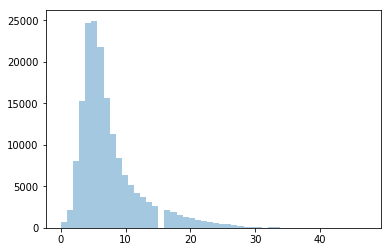

In [38]:
sns.distplot([len(entity) for entity in entities], hist=True, kde=False);

In [52]:
entities = [sorted(sorted(entity, key=lambda x: ecnts[x])[:5]) 
            for entity in tqdm_notebook(entities)]
assert len(descs) == len(entities)
len(entities)

HBox(children=(IntProgress(value=0, max=171161), HTML(value='')))

171161

In [53]:
edescs = [', '.join(entity) + ' | ' + desc for desc, entity in zip(descs, entities)]
assert len(descs) == len(edescs)
len(edescs)

171161

In [54]:
random.sample(edescs, 10)

['an rds instance, index, inventory, rds, the inventory | Adds an RDS instance to the inventory and index, as long as it is DCNL addressable',
 'a new accountsettings object, accountsettings, attribute, the given user, user | Creates a new AccountSettings object for the given user and populates it with the given DCNL attributes.',
 'epoch, seconds, the current number, the unix epoch, unix | Return the current number of seconds since the Unix epoch, DCNL as a string.',
 'ax, functionality, the zoom box button functionality, this axes, zoom | Return *True* if this axes supports the zoom box button functionality.',
 'determine, determines, query, the query, use | Determines which method of getting the query object for use',
 'arg, dataflowhook, test, test dataflowhook, the right args | Test DataFlowHook is created and the right args are passed to DCNL start_python_workflow.',
 '(activation) url, `none`, `request, the email confirmation, your system | Constructs the email confirmation (act

In [55]:
%store edescs

Stored 'edescs' (list)
